# Training MF
In this notebook, we train the MF model on the train interaction matrix + masked validation interactions.

Now, to train the model, we can't simply create the full interaction matrix, as it would be too large to fit in memory. The idea is instead to represent the matrix as a sparse matrix. To then run ALS on this sparse matrix, we use the `implicit` library, which handles the sparse matrix representation internally and takes care of the computations with sparse matrices. (The goal of this project is not to implement ALS from scratch, but rather to use it as a baseline model for comparison with the Two Towers model, which is why we use the `implicit` library here.)

Note: You must have Visual Studio installed on Windows to be able to install the `implicit` library. On linux, it should work directly. Otherwise, if you get an error regarding scikit-build, follow the error's instruction.

In [16]:
import implicit
from scipy.sparse import csr_matrix
import pandas as pd

df_mf_train = pd.read_csv('data/large/train/processed/mf_interactions.csv')
df_mf_val = pd.read_csv('data/large/dev/processed/mf_interactions.csv')

# Load the interaction data
def load_interaction_data(df_train=df_mf_train, df_val=df_mf_val):
    """
    Since MF can't handle new users/items at inference time, we will limit the interaction matrix to the users/items seen at least once in the trainset.
    """
    df_train = df_train.copy()
    df_val = df_val.copy()

    unique_users = df_train['user_id'].unique()
    print(f"Unique users in total: {len(unique_users)}")
    unique_news = df_train['news_id'].unique()
    print(f"Unique news in total: {len(unique_news)}")
    user_id_to_idx = {user_id: idx for idx, user_id in enumerate(unique_users)}
    news_id_to_idx = {news_id: idx for idx, news_id in enumerate(unique_news)}
    idx_to_user_id = {idx: user_id for user_id, idx in user_id_to_idx.items()}
    idx_to_news_id = {idx: news_id for news_id, idx in news_id_to_idx.items()}

    # Limit validation set to users/items seen in training set
    df_val = df_val[df_val['user_id'].isin(unique_users) & df_val['news_id'].isin(unique_news)]
    print(f"Validation interactions after filtering unseen users/items: {len(df_val)}")

    df_train['user_id'] = df_train['user_id'].map(user_id_to_idx)
    df_train['news_id'] = df_train['news_id'].map(news_id_to_idx)
    df_val['user_id'] = df_val['user_id'].map(user_id_to_idx)
    df_val['news_id'] = df_val['news_id'].map(news_id_to_idx)
    train_interaction_matrix = csr_matrix((df_train['label'], (df_train['user_id'], df_train['news_id'])), shape=(len(unique_users), len(unique_news)))
    val_interaction_matrix = csr_matrix((df_val['label'], (df_val['user_id'], df_val['news_id'])), shape=(len(unique_users), len(unique_news)))
    return train_interaction_matrix, val_interaction_matrix, idx_to_user_id, user_id_to_idx, idx_to_news_id, news_id_to_idx

interaction_matrix, val_interaction_matrix, idx_to_user_id, user_id_to_idx, idx_to_news_id, news_id_to_idx = load_interaction_data()
interaction_matrix, val_interaction_matrix

Unique users in total: 711222
Unique news in total: 17304
Validation interactions after filtering unseen users/items: 357329


(<Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 3356405 stored elements and shape (711222, 17304)>,
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 357329 stored elements and shape (711222, 17304)>)

In [17]:
als = implicit.als.AlternatingLeastSquares(factors=50, regularization=0.1, iterations=20, calculate_training_loss=True)

  0%|          | 0/20 [00:00<?, ?it/s]

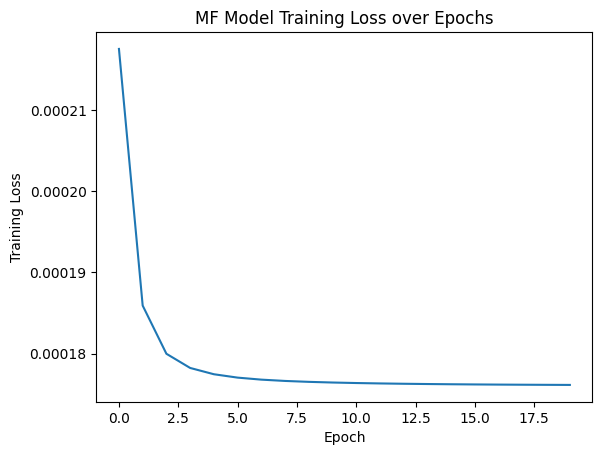

In [18]:
import matplotlib.pyplot as plt


mf_loss_history = []

def history_callback(epoch, elapsed_time, progress):
    mf_loss_history.append(progress)

als.fit(interaction_matrix, callback=history_callback)

plt.plot(mf_loss_history)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('MF Model Training Loss over Epochs')
plt.show()

In [19]:
import json


converters = {
    'idx_to_user_id': idx_to_user_id, 
    'user_id_to_idx': user_id_to_idx, 
    'idx_to_news_id': idx_to_news_id,
    'news_id_to_idx': news_id_to_idx
}

with open("converters_mf.json", "w") as json_file:
    json.dump(converters, json_file, indent=4)

In [20]:
als.save('mf_model.npz')

In [21]:
import scipy.sparse

scipy.sparse.save_npz('val_interaction_matrix.npz', val_interaction_matrix)
scipy.sparse.save_npz('train_interaction_matrix.npz', interaction_matrix)